# AI Algorithms Project - Option B
Gabriel SULTAN - Lalith Adithya CHANUMOLU - DIA 6

#  Cost and Performance Optimization for Application Deployment and Scaling

**Problem Context and Motivation :** 
#
Modern Machine Learning models, especially in fields like Deep Learning, are becoming increasingly
large and complex. Training these models on a single machine can take weeks or even months, creating a
significant bottleneck in the AI development cycle. To accelerate this process, companies use distributed
training, where the computational workload is spread across multiple machines in a cloud environment.
This approach can drastically reduce training time, but it introduces a major challenge: cost and
resource management.


The objective is to configure the training cluster to minimize the total hourly infrastructure cost while ensuring the training process is stable and efficient

## 2. Problem Formulation

### 2.1. Sets and Indices

- **I** = {1, 2, 3, 4} : set of application components
- **J** : set of available virtual machine (VM) types
- **T** : set of time periods (if the problem is dynamic)

### 2.2. Parameters

For each component **i ∈ I** :
- **μᵢ** : service rate of component i (requests/second per replica)
- **λᵢ** : maximum arrival rate for component i (requests/second)
- **rᵢᵐⁱⁿ** : minimum number of replicas required for component i

For each VM type **j ∈ J** :
- **CPUⱼ** : number of CPUs available on a VM of type j
- **RAMⱼ** : amount of RAM available on a VM of type j (in GiB)
- **Costⱼ** : hourly cost of a VM of type j
- **Quantityⱼ** : maximum number of VMs of type j available
- **Rⱼ** : maximum number of replicas that a VM of type j can host
  - Rⱼ = min(CPUⱼ, ⌊RAMⱼ / 0.25⌋)

Global parameters :
- **CPU_req** = 1 : number of CPUs required per replica
- **RAM_req** = 0.25 : amount of RAM required per replica (in GiB)

### 2.3. Decision Variables

- **rᵢ** ∈ ℤ⁺ : number of replicas allocated to component i (i ∈ I)
- **xⱼ** ∈ ℤ⁺ : number of VMs of type j to deploy (j ∈ J)
- **yᵢⱼ** ∈ ℤ⁺ : number of replicas of component i placed on VMs of type j (optional, for explicit placement modeling)

### 2.4. Objective Function

Minimize the total hourly infrastructure cost :

$$\min Z = \sum_{j \in J} x_j \cdot \text{Cost}_j$$

### 2.5. Constraints

#### 2.5.1. Service Stability

For each component i, the number of replicas must be sufficient to handle the maximum load :

$$r_i \cdot \mu_i \geq \lambda_i, \quad \forall i \in I$$

or equivalently :

$$r_i \geq \left\lceil \frac{\lambda_i}{\mu_i} \right\rceil = r_i^{min}, \quad \forall i \in I$$

#### 2.5.2. CPU Resource Sufficiency

The total CPU capacity of the cluster must be at least equal to the total demand :

$$\sum_{j \in J} x_j \cdot \text{CPU}_j \geq \sum_{i \in I} r_i \cdot \text{CPU}_{req}$$

$$\sum_{j \in J} x_j \cdot \text{CPU}_j \geq \sum_{i \in I} r_i$$

#### 2.5.3. RAM Resource Sufficiency

The total RAM capacity of the cluster must be at least equal to the total demand :

$$\sum_{j \in J} x_j \cdot \text{RAM}_j \geq \sum_{i \in I} r_i \cdot \text{RAM}_{req}$$

$$\sum_{j \in J} x_j \cdot \text{RAM}_j \geq 0.25 \cdot \sum_{i \in I} r_i$$

#### 2.5.4. VM Availability

The number of VMs of each type cannot exceed the available quantity :

$$x_j \leq \text{Quantity}_j, \quad \forall j \in J$$

#### 2.5.5. Valid Replica Placement

The total number of placed replicas cannot exceed the total capacity of the cluster :

$$\sum_{i \in I} r_i \leq \sum_{j \in J} x_j \cdot R_j$$

This constraint ensures that each VM can host at most Rⱼ replicas.

#### 2.5.6. Domain Constraints

$$r_i \in \mathbb{Z}^+, \quad \forall i \in I$$
$$x_j \in \mathbb{Z}^+, \quad \forall j \in J$$

### 2.6. Model Summary

**Problem Type** : Integer Linear Program (ILP)

**Objective** : Cost minimization

**Complexity** : NP-hard (combinatorial optimization with integer variables)

**Possible Solution Methods** :
- Branch and Bound
- Heuristic algorithms (greedy, simulated annealing, etc.)
- ILP solvers (CPLEX, Gurobi, OR-Tools)


# 1: Files Loading

In [25]:
import pandas as pd
import numpy as np
#we load both files in a dataframe so it's easier to use
df_vm =pd.read_csv('VM_Catalogue.csv', sep=';')
df_workload = pd.read_csv('Workload.csv', sep=';') 


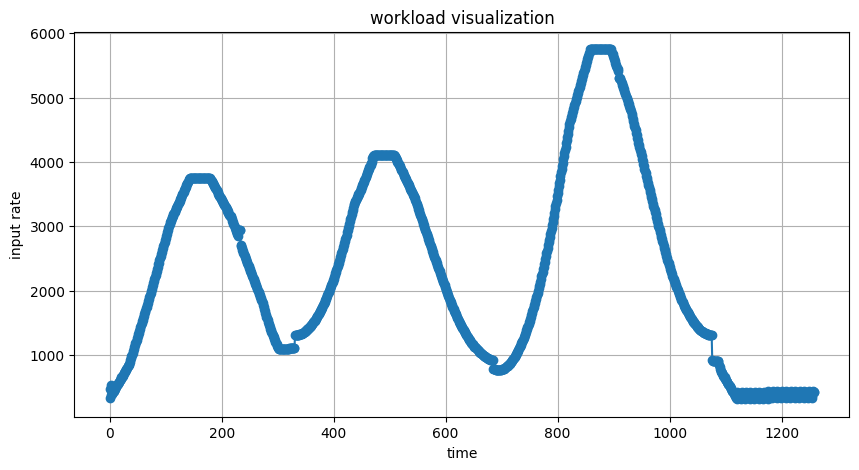

In [ ]:
#plotting the workload as this is done in the Project Statement
#It ensures that the workload is properly loaded 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_workload['time'], df_workload['input_rate'], marker='o')
plt.title("workload visualization")
plt.xlabel("time")
plt.ylabel("input rate")
plt.grid(True)
plt.show()


In [12]:
# First, ensure numeric types where possible (row 0 might be header in the CSV)
df_vm_clean = df_vm.copy()
df_vm_clean.columns = df_vm_clean.iloc[0]  # set the first real row as header
df_vm_clean = df_vm_clean[1:]  # drop the "double header" row
df_vm_clean = df_vm_clean.reset_index(drop=True)

#Convert all columns to numeric
df_vm_clean['CPU'] = pd.to_numeric(df_vm_clean['CPU'])
df_vm_clean['RAM'] = pd.to_numeric(df_vm_clean['RAM'])
df_vm_clean['Cost'] = pd.to_numeric(df_vm_clean['Cost'])
df_vm_clean['Quantity'] = pd.to_numeric(df_vm_clean['Quantity'])

df_vm_clean.head()

,Type,CPU,RAM,Cost,Quantity
0,T00,1,3.75,0.1914,10
1,T01,2,1.80,0.2104,10
2,T02,2,7.50,0.2684,10
3,T03,2,13.00,0.2944,10
4,T04,4,3.60,0.3064,10


Now that our files are properly loaded, what we want to do is to compute how replicas each VM can host. 
As a reminder, a replica needs 1 CPU and 0.25 Gib of RAM. 

the variable max_replicas here is Ri (as given in the project statement).

In [19]:
# Compute for each VM
df_vm_clean['max_replicas']=df_vm_clean.apply(
    lambda row:min(
        int(row['CPU'] // 1),
        int(row['RAM']// 0.25)),
    axis= 1
)

df_vm_clean[ ['Type','max_replicas']] #show each VM with their max replicas


,Type,max_replicas
0,T00,1
1,T01,2
2,T02,2
3,T03,2
4,T04,4
5,T05,4
6,T06,4
7,T07,8
8,T08,8
9,T09,8


Let's add the cost per replica

In [18]:
df_vm_clean['cost_per_replica'] =df_vm_clean.apply(
    lambda row: row['Cost'] / row['max_replicas'],
    axis=1)

#display
df_vm_clean[ ['Type','max_replicas', 'Cost','cost_per_replica']]


,Type,max_replicas,Cost,cost_per_replica
0,T00,1,0.1914,0.191400
1,T01,2,0.2104,0.105200
2,T02,2,0.2684,0.134200
3,T03,2,0.2944,0.147200
4,T04,4,0.3064,0.076600
5,T05,4,0.4224,0.105600
6,T06,4,0.4744,0.118600
7,T07,8,0.4984,0.062300
8,T08,8,0.7304,0.091300
9,T09,8,0.8344,0.104300


In [20]:
# μ per component (given in the statement)
mu = {1:1416, 2:696, 3:1005, 4:1259}

In [23]:
#look at the peak workload
peak_workload= df_workload['input_rate'].max()
print(f"peak workload: {peak_workload}")


peak workload: 5751


In [ ]:
#calculate r_min for each component
r_min = {}
for comp_id, mu_c in mu.items():
    r_min[comp_id] = int(np.ceil(peak_workload / mu_c))
print("r_min for each component:")
for comp_id in r_min:
    print(f"Component {comp_id}: r_min = {r_min[comp_id]}")


r_min for each component:
Component 1: r_min = 5
Component 2: r_min = 9
Component 3: r_min = 6
Component 4: r_min = 5


## 2. Formulation Mathématique du Problème

### 2.1. Ensembles et Indices

- **I** = {1, 2, 3, 4} : ensemble des composants de l'application
- **J** : ensemble des types de machines virtuelles (VM) disponibles
- **T** : ensemble des périodes de temps (si le problème est dynamique)

### 2.2. Paramètres

Pour chaque composant **i ∈ I** :
- **μᵢ** : taux de service du composant i (requêtes/seconde par réplique)
- **λᵢ** : taux d'arrivée maximal pour le composant i (requêtes/seconde)
- **rᵢᵐⁱⁿ** : nombre minimum de répliques requis pour le composant i

Pour chaque type de VM **j ∈ J** :
- **CPUⱼ** : nombre de CPU disponibles sur une VM de type j
- **RAMⱼ** : quantité de RAM disponible sur une VM de type j (en GiB)
- **Costⱼ** : coût horaire d'une VM de type j
- **Quantityⱼ** : nombre maximum de VM de type j disponibles
- **Rⱼ** : nombre maximum de répliques qu'une VM de type j peut héberger
  - Rⱼ = min(CPUⱼ, ⌊RAMⱼ / 0.25⌋)

Paramètres globaux :
- **CPU_req** = 1 : nombre de CPU requis par réplique
- **RAM_req** = 0.25 : quantité de RAM requise par réplique (en GiB)

### 2.3. Variables de Décision

- **rᵢ** ∈ ℤ⁺ : nombre de répliques allouées au composant i (i ∈ I)
- **xⱼ** ∈ ℤ⁺ : nombre de VM de type j à déployer (j ∈ J)
- **yᵢⱼ** ∈ ℤ⁺ : nombre de répliques du composant i placées sur des VM de type j (optionnel, pour modéliser le placement explicite)

### 2.4. Fonction Objectif

Minimiser le coût total horaire de l'infrastructure :

$$\min Z = \sum_{j \in J} x_j \cdot \text{Cost}_j$$

### 2.5. Contraintes

#### 2.5.1. Stabilité des Services (Service Stability)

Pour chaque composant i, le nombre de répliques doit être suffisant pour gérer la charge maximale :

$$r_i \cdot \mu_i \geq \lambda_i, \quad \forall i \in I$$

ou de manière équivalente :

$$r_i \geq \left\lceil \frac{\lambda_i}{\mu_i} \right\rceil = r_i^{min}, \quad \forall i \in I$$

#### 2.5.2. Suffisance des Ressources CPU

La capacité CPU totale du cluster doit être au moins égale à la demande totale :

$$\sum_{j \in J} x_j \cdot \text{CPU}_j \geq \sum_{i \in I} r_i \cdot \text{CPU}_{req}$$

$$\sum_{j \in J} x_j \cdot \text{CPU}_j \geq \sum_{i \in I} r_i$$

#### 2.5.3. Suffisance des Ressources RAM

La capacité RAM totale du cluster doit être au moins égale à la demande totale :

$$\sum_{j \in J} x_j \cdot \text{RAM}_j \geq \sum_{i \in I} r_i \cdot \text{RAM}_{req}$$

$$\sum_{j \in J} x_j \cdot \text{RAM}_j \geq 0.25 \cdot \sum_{i \in I} r_i$$

#### 2.5.4. Disponibilité des VM (VM Availability)

Le nombre de VM de chaque type ne peut pas dépasser la quantité disponible :

$$x_j \leq \text{Quantity}_j, \quad \forall j \in J$$

#### 2.5.5. Placement Valide des Répliques

Le nombre total de répliques placées ne peut pas dépasser la capacité totale du cluster :

$$\sum_{i \in I} r_i \leq \sum_{j \in J} x_j \cdot R_j$$

Cette contrainte garantit que chaque VM ne peut héberger qu'un maximum de Rⱼ répliques.

#### 2.5.6. Contraintes de Domaine

$$r_i \in \mathbb{Z}^+, \quad \forall i \in I$$
$$x_j \in \mathbb{Z}^+, \quad \forall j \in J$$

### 2.6. Résumé du Modèle

**Type de problème** : Programme Linéaire en Nombres Entiers (PLNE / ILP)

**Objectif** : Minimisation du coût

**Complexité** : NP-difficile (optimisation combinatoire avec variables entières)

**Méthodes de résolution possibles** :
- Branch and Bound
- Algorithmes heuristiques (glouton, recuit simulé, etc.)
- Solveurs PLNE (CPLEX, Gurobi, OR-Tools)